**Case 3: CVA Equity Derivatives**

In [1]:
### Library Imports ###
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass
from typing import Tuple

np.random.seed(42)

### Data and Parameters ###

# Credit Data (Counterparty "C")
LGD = 0.40

# Forward hazard rates (piecewise constant)
hazard_rates = {
    'periods': [(0, 1), (1, 3), (3, 5)],
    'lambdas': [0.0200, 0.0215, 0.0220]
}

# Interest Rates
r = 0.03  # Risk-free rate (continuously compounded)

# Equity Parameters
q = 0.02  # Dividend yield (both assets)
sigma_SX5E = 0.15  # STOXX50 volatility
sigma_AEX = 0.15   # AEX volatility
rho = 0.80         # Correlation between assets

S0_SX5E = 6000     # Initial STOXX50 level
S0_AEX = 1000      # Initial AEX level

# Time parameters
T = 5.0            # Maturity in years
dt = 1/12          # Monthly timesteps
n_steps = int(T / dt)  # 60 monthly steps
time_grid = np.linspace(0, T, n_steps + 1)

# Monte Carlo parameters
n_simulations = 100000

### Portfolio ###

portfolio = pd.DataFrame({
    'Instrument': [1, 2, 3, 4],
    'Type': ['Forward', 'Forward', 'Option', 'Option'],
    'Position': ['Long', 'Long', 'Put', 'Put'],
    'Underlying': ['SX5E', 'AEX', 'SX5E', 'AEX'],
    'Contracts': [10000, 55000, 10000, 55000],
    'S0': [6000, 1000, 6000, 1000],
    'Strike': [6000, 1000, 4800, 800],
    'Volatility': [np.nan, np.nan, 0.15, 0.15],
    'Maturity': [5, 5, 5, 5]
})

### Hazard Rate Function ###

def get_hazard_rate(t: float) -> float:
    """Return forward hazard rate at time t"""
    for (t_start, t_end), lambda_val in zip(hazard_rates['periods'], hazard_rates['lambdas']):
        if t_start <= t < t_end or (t == T and t_end == T):
            return lambda_val
    return hazard_rates['lambdas'][-1]

def survival_probability(t: float) -> float:
    """Calculate survival probability Q(t) = exp(-∫λ(s)ds from 0 to t)"""
    integral = 0.0
    for (t_start, t_end), lambda_val in zip(hazard_rates['periods'], hazard_rates['lambdas']):
        if t <= t_start:
            break
        interval_end = min(t, t_end)
        integral += lambda_val * (interval_end - t_start)
    return np.exp(-integral)

def default_probability(t1: float, t2: float) -> float:
    """Calculate probability of default in interval [t1, t2]"""
    return survival_probability(t1) - survival_probability(t2)

In [2]:
### Simulation Definitions

def generate_correlated_normals(n_paths: int, n_steps: int, rho: float) -> Tuple[np.ndarray, np.ndarray]:
    """Generate correlated standard normals using Cholesky decomposition"""
    corr_matrix = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(corr_matrix)
    Z_independent = np.random.standard_normal((n_paths, n_steps, 2))
    Z_correlated = Z_independent @ L.T
    return Z_correlated[:, :, 0], Z_correlated[:, :, 1]


def simulate_equity_paths(S0: float, sigma: float, Z: np.ndarray) -> np.ndarray:
    """Simulate equity paths using GBM: S(t+Δ) = S(t) * exp[(r-q-0.5*σ²)Δ + σ*Z*√Δ]"""
    n_paths, n_steps_Z = Z.shape
    S = np.zeros((n_paths, n_steps_Z + 1))
    S[:, 0] = S0
    
    drift = (r - q - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)
    
    for i in range(n_steps_Z):
        S[:, i+1] = S[:, i] * np.exp(drift + diffusion * Z[:, i])
    
    return S


def black_scholes_put(S: float, K: float, T: float, r: float, q: float, sigma: float) -> float:
    """Black-Scholes-Merton formula for European put option"""
    if T <= 0:
        return np.maximum(K - S, 0)
    
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * np.exp(-q * T) * norm.cdf(-d1)


def value_instrument(S: float, instrument_row: pd.Series, tau: float) -> float:
    """Value a single instrument at remaining time tau"""
    K = instrument_row['Strike']
    contracts = instrument_row['Contracts']
    
    if tau <= 0:
        if instrument_row['Type'] == 'Forward':
            return contracts * (S - K)
        else:
            return contracts * np.maximum(K - S, 0)
    
    if instrument_row['Type'] == 'Forward':
        forward_price = S * np.exp((r - q) * tau)
        return contracts * (forward_price - K) * np.exp(-r * tau)
    else:
        return contracts * black_scholes_put(S, K, tau, r, q, instrument_row['Volatility'])


def value_portfolio_at_time(S_SX5E: np.ndarray, S_AEX: np.ndarray, 
                            time_idx: int, portfolio_df: pd.DataFrame) -> dict:
    """Value entire portfolio at given time index for all paths"""
    t = time_grid[time_idx]
    tau = T - t
    
    values = {}
    
    for idx, row in portfolio_df.iterrows():
        instr_num = row['Instrument']
        S = S_SX5E[:, time_idx] if row['Underlying'] == 'SX5E' else S_AEX[:, time_idx]
        values[instr_num] = np.array([value_instrument(s, row, tau) for s in S])
    
    values['total'] = sum(values[i] for i in [1, 2, 3, 4])
    
    return values


### Simulation

print("\nRunning Monte Carlo simulation with", f"{n_simulations:,}", "paths")

Z_SX5E, Z_AEX = generate_correlated_normals(n_simulations, n_steps, rho)
S_SX5E_paths = simulate_equity_paths(S0_SX5E, sigma_SX5E, Z_SX5E)
S_AEX_paths = simulate_equity_paths(S0_AEX, sigma_AEX, Z_AEX)
print(f"SX5E at T=5: Mean = {S_SX5E_paths[:, -1].mean():.2f}, Std = {S_SX5E_paths[:, -1].std():.2f}")
print(f"AEX at T=5:  Mean = {S_AEX_paths[:, -1].mean():.2f}, Std = {S_AEX_paths[:, -1].std():.2f}")




Running Monte Carlo simulation with 100,000 paths
SX5E at T=5: Mean = 6297.45, Std = 2171.93
AEX at T=5:  Mean = 1049.65, Std = 360.25


**Q1**

In [3]:
### Question 1: Model Validation

## a) Martingale Test - Forward Contracts

print("\n### Question 1a: Martingale Test (Forwards)")

# Theoretical values at t=0
forward_1_theoretical = value_instrument(S0_SX5E, portfolio.iloc[0], T)
forward_2_theoretical = value_instrument(S0_AEX, portfolio.iloc[1], T)

print(f"Forward 1 (SX5E) - Theoretical value: {forward_1_theoretical:,.2f}")
print(f"Forward 2 (AEX)  - Theoretical value: {forward_2_theoretical:,.2f}")

# Simulated payoffs at maturity
forward_1_payoff = portfolio.iloc[0]['Contracts'] * (S_SX5E_paths[:, -1] - portfolio.iloc[0]['Strike'])
forward_2_payoff = portfolio.iloc[1]['Contracts'] * (S_AEX_paths[:, -1] - portfolio.iloc[1]['Strike'])

# Discount to t=0
discount_factor = np.exp(-r * T)
forward_1_pv = forward_1_payoff * discount_factor
forward_2_pv = forward_2_payoff * discount_factor

# Monte Carlo estimates and standard errors
forward_1_mean = forward_1_pv.mean()
forward_1_se = forward_1_pv.std() / np.sqrt(n_simulations)
forward_1_ci = (forward_1_mean - 1.96 * forward_1_se, forward_1_mean + 1.96 * forward_1_se)

forward_2_mean = forward_2_pv.mean()
forward_2_se = forward_2_pv.std() / np.sqrt(n_simulations)
forward_2_ci = (forward_2_mean - 1.96 * forward_2_se, forward_2_mean + 1.96 * forward_2_se)

print(f"\nForward 1 - MC estimate: {forward_1_mean:,.2f}")
print(f"            95% CI: [{forward_1_ci[0]:,.2f}, {forward_1_ci[1]:,.2f}]")
print(f"            Standard error: {forward_1_se:,.2f}")
print(f"            Theoretical value in CI: {forward_1_ci[0] <= forward_1_theoretical <= forward_1_ci[1]}")

print(f"\nForward 2 - MC estimate: {forward_2_mean:,.2f}")
print(f"            95% CI: [{forward_2_ci[0]:,.2f}, {forward_2_ci[1]:,.2f}]")
print(f"            Standard error: {forward_2_se:,.2f}")
print(f"            Theoretical value in CI: {forward_2_ci[0] <= forward_2_theoretical <= forward_2_ci[1]}")


## b) Option Pricing Test - Put Options

print("\n\n### Question 1b: Option Pricing Test (Puts)")

# Theoretical Black-Scholes values at t=0
put_1_theoretical = value_instrument(S0_SX5E, portfolio.iloc[2], T)
put_2_theoretical = value_instrument(S0_AEX, portfolio.iloc[3], T)

print(f"Put 1 (SX5E) - Black-Scholes value: {put_1_theoretical:,.2f}")
print(f"Put 2 (AEX)  - Black-Scholes value: {put_2_theoretical:,.2f}")

# Simulated payoffs at maturity
put_1_payoff = portfolio.iloc[2]['Contracts'] * np.maximum(portfolio.iloc[2]['Strike'] - S_SX5E_paths[:, -1], 0)
put_2_payoff = portfolio.iloc[3]['Contracts'] * np.maximum(portfolio.iloc[3]['Strike'] - S_AEX_paths[:, -1], 0)

# Discount to t=0
put_1_pv = put_1_payoff * discount_factor
put_2_pv = put_2_payoff * discount_factor

# Monte Carlo estimates and standard errors
put_1_mean = put_1_pv.mean()
put_1_se = put_1_pv.std() / np.sqrt(n_simulations)
put_1_ci = (put_1_mean - 1.96 * put_1_se, put_1_mean + 1.96 * put_1_se)

put_2_mean = put_2_pv.mean()
put_2_se = put_2_pv.std() / np.sqrt(n_simulations)
put_2_ci = (put_2_mean - 1.96 * put_2_se, put_2_mean + 1.96 * put_2_se)

print(f"\nPut 1 - MC estimate: {put_1_mean:,.2f}")
print(f"        95% CI: [{put_1_ci[0]:,.2f}, {put_1_ci[1]:,.2f}]")
print(f"        Standard error: {put_1_se:,.2f}")
print(f"        Black-Scholes value in CI: {put_1_ci[0] <= put_1_theoretical <= put_1_ci[1]}")

print(f"\nPut 2 - MC estimate: {put_2_mean:,.2f}")
print(f"        95% CI: [{put_2_ci[0]:,.2f}, {put_2_ci[1]:,.2f}]")
print(f"        Standard error: {put_2_se:,.2f}")
print(f"        Black-Scholes value in CI: {put_2_ci[0] <= put_2_theoretical <= put_2_ci[1]}")


## c) Correlation Structure Check

print("\n\n### Question 1c: Correlation Structure Check")

# Calculate log-returns
log_returns_SX5E = np.diff(np.log(S_SX5E_paths), axis=1)
log_returns_AEX = np.diff(np.log(S_AEX_paths), axis=1)

# Flatten to get all log-returns across paths and time
log_ret_SX5E_flat = log_returns_SX5E.flatten()
log_ret_AEX_flat = log_returns_AEX.flatten()

# Calculate sample correlation
sample_correlation = np.corrcoef(log_ret_SX5E_flat, log_ret_AEX_flat)[0, 1]

# Fisher z-transformation for confidence interval
n_observations = len(log_ret_SX5E_flat)
z = 0.5 * np.log((1 + sample_correlation) / (1 - sample_correlation))
se_z = 1 / np.sqrt(n_observations - 3)
z_ci = (z - 1.96 * se_z, z + 1.96 * se_z)

# Transform back to correlation space
corr_ci_lower = (np.exp(2 * z_ci[0]) - 1) / (np.exp(2 * z_ci[0]) + 1)
corr_ci_upper = (np.exp(2 * z_ci[1]) - 1) / (np.exp(2 * z_ci[1]) + 1)

print(f"Sample correlation: {sample_correlation:.4f}")
print(f"95% CI (Fisher z-transform): [{corr_ci_lower:.4f}, {corr_ci_upper:.4f}]")
print(f"Number of observations: {n_observations:,}")
print(f"Theoretical correlation (0.80) in CI: {corr_ci_lower <= rho <= corr_ci_upper}")

### Q1 convergence tables (CI width + difference vs theoretical)

# Choose N grid (trim to available number of paths)
Ns = [1000, 5000, 10000, 50000, 100000]
Ns = [N for N in Ns]

z = 1.96

def mc_ci_width(x, N):
    se = x[:N].std(ddof=1) / np.sqrt(N)
    return 2 * z * se

def mc_diff(x, N, theo):
    return x[:N].mean() - theo

# --- Build discounted payoff arrays (recompute safely) ---
df_T = np.exp(-r * T)

fwd1_pv = portfolio.iloc[0]["Contracts"] * (S_SX5E_paths[:, -1] - portfolio.iloc[0]["Strike"]) * df_T
fwd2_pv = portfolio.iloc[1]["Contracts"] * (S_AEX_paths[:, -1]  - portfolio.iloc[1]["Strike"]) * df_T

put1_pv = portfolio.iloc[2]["Contracts"] * np.maximum(portfolio.iloc[2]["Strike"] - S_SX5E_paths[:, -1], 0) * df_T
put2_pv = portfolio.iloc[3]["Contracts"] * np.maximum(portfolio.iloc[3]["Strike"] - S_AEX_paths[:, -1],  0) * df_T

# Theoretical values at t=0 (already computed earlier, but recompute safely)
fwd1_theo = value_instrument(S0_SX5E, portfolio.iloc[0], T)
fwd2_theo = value_instrument(S0_AEX,  portfolio.iloc[1], T)
put1_theo = value_instrument(S0_SX5E, portfolio.iloc[2], T)
put2_theo = value_instrument(S0_AEX,  portfolio.iloc[3], T)

# --- Q1a table (Forwards) ---
q1a_rows = []
for N in Ns:
    q1a_rows.append({
        "N": N,
        "Fwd1_CI_width": mc_ci_width(fwd1_pv, N),
        "Fwd1_mean_minus_theo": mc_diff(fwd1_pv, N, fwd1_theo),
        "Fwd2_CI_width": mc_ci_width(fwd2_pv, N),
        "Fwd2_mean_minus_theo": mc_diff(fwd2_pv, N, fwd2_theo),
    })
q1a_df = pd.DataFrame(q1a_rows)
print("\nQ1a convergence (forwards):")
print(q1a_df.to_string(index=False))

# --- Q1b table (Puts) ---
q1b_rows = []
for N in Ns:
    q1b_rows.append({
        "N": N,
        "Put1_CI_width": mc_ci_width(put1_pv, N),
        "Put1_mean_minus_BS": mc_diff(put1_pv, N, put1_theo),
        "Put2_CI_width": mc_ci_width(put2_pv, N),
        "Put2_mean_minus_BS": mc_diff(put2_pv, N, put2_theo),
    })
q1b_df = pd.DataFrame(q1b_rows)
print("\nQ1b convergence (puts):")
print(q1b_df.to_string(index=False))

# --- Q1c table (Correlation) ---
def fisher_ci_width_and_diff(N):
    lr1 = np.diff(np.log(S_SX5E_paths[:N, :]), axis=1).ravel()
    lr2 = np.diff(np.log(S_AEX_paths[:N, :]), axis=1).ravel()

    rho_hat = np.corrcoef(lr1, lr2)[0, 1]
    n_obs = len(lr1)

    # Fisher z CI
    z_hat = 0.5 * np.log((1 + rho_hat) / (1 - rho_hat))
    se_z = 1 / np.sqrt(n_obs - 3)
    z_lo, z_hi = z_hat - 1.96 * se_z, z_hat + 1.96 * se_z
    rho_lo = (np.exp(2 * z_lo) - 1) / (np.exp(2 * z_lo) + 1)
    rho_hi = (np.exp(2 * z_hi) - 1) / (np.exp(2 * z_hi) + 1)

    return rho_hat, (rho_hi - rho_lo), (rho_hat - rho)

q1c_rows = []
for N in Ns:
    rho_hat, ci_w, diff = fisher_ci_width_and_diff(N)
    q1c_rows.append({
        "N": N,
        "rho_hat": rho_hat,
        "Corr_CI_width": ci_w,
        "rho_hat_minus_target": diff
    })
q1c_df = pd.DataFrame(q1c_rows)
print("\nQ1c convergence (correlation):")
print(q1c_df.to_string(index=False))




### Question 1a: Martingale Test (Forwards)
Forward 1 (SX5E) - Theoretical value: 2,647,766.50
Forward 2 (AEX)  - Theoretical value: 2,427,119.29

Forward 1 - MC estimate: 2,560,205.02
            95% CI: [2,444,338.78, 2,676,071.25]
            Standard error: 59,115.42
            Theoretical value in CI: True

Forward 2 - MC estimate: 2,350,321.04
            95% CI: [2,244,621.43, 2,456,020.66]
            Standard error: 53,928.38
            Theoretical value in CI: True


### Question 1b: Option Pricing Test (Puts)
Put 1 (SX5E) - Black-Scholes value: 1,846,183.04
Put 2 (AEX)  - Black-Scholes value: 1,692,334.46

Put 1 - MC estimate: 1,866,165.32
        95% CI: [1,840,714.87, 1,891,615.78]
        Standard error: 12,984.93
        Black-Scholes value in CI: True

Put 2 - MC estimate: 1,689,407.86
        95% CI: [1,666,226.49, 1,712,589.24]
        Standard error: 11,827.23
        Black-Scholes value in CI: True


### Question 1c: Correlation Structure Check
Sample correlation

**Q2**


### Question 2a: Netted Exposure Profile (EPE)
EPE at inception (t=0): 8,613,403.28
Peak EPE: 17,912,061.36 at t=5.00 years
EPE at maturity (t=5): 17,912,061.36


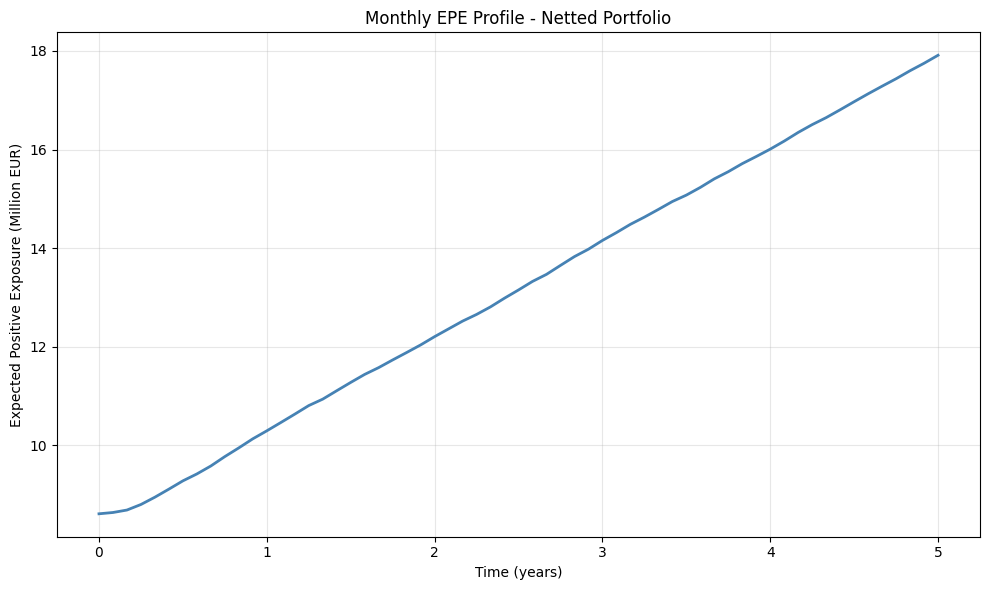



### Question 2b: Standalone CVA (Individual Contracts)
Instrument 1 (Forward Long SX5E): CVA = 251,351.48
Instrument 2 (Forward Long AEX): CVA = 229,928.05
Instrument 3 (Option Put SX5E): CVA = 75,456.40
Instrument 4 (Option Put AEX): CVA = 68,910.14

Total Standalone CVA (sum): 625,646.06


### Question 2c: Unnetted Portfolio CVA
Unnetted Portfolio CVA: 625,646.06
Average EPE (unnetted): 16,650,994.93


### Question 2d: Netted Portfolio CVA
Netted Portfolio CVA: 493,734.00
Average EPE (netted): 13,161,015.57


### Question 2e: Netting Benefit Analysis

Netting Benefit: 131,912.07 (21.1%)

CVA Summary:
  - Unnetted: 625,646.06
  - Netted:   493,734.00
  - Savings:  131,912.07


In [4]:
### Question 2: Exposures and CVA

## Vectorized Portfolio Valuation

# Pre-compute all portfolio values across time
n_paths = S_SX5E_paths.shape[0]
V1_all = np.zeros((n_paths, n_steps + 1))
V2_all = np.zeros((n_paths, n_steps + 1))
V3_all = np.zeros((n_paths, n_steps + 1))
V4_all = np.zeros((n_paths, n_steps + 1))

for time_idx in range(n_steps + 1):
    t = time_grid[time_idx]
    tau = T - t
    
    S_SX5E = S_SX5E_paths[:, time_idx]
    S_AEX = S_AEX_paths[:, time_idx]
    
    # Forward 1: Long SX5E
    if tau > 0:
        F1 = S_SX5E * np.exp((r - q) * tau)
        V1_all[:, time_idx] = portfolio.iloc[0]['Contracts'] * (F1 - portfolio.iloc[0]['Strike']) * np.exp(-r * tau)
    else:
        V1_all[:, time_idx] = portfolio.iloc[0]['Contracts'] * (S_SX5E - portfolio.iloc[0]['Strike'])
    
    # Forward 2: Long AEX
    if tau > 0:
        F2 = S_AEX * np.exp((r - q) * tau)
        V2_all[:, time_idx] = portfolio.iloc[1]['Contracts'] * (F2 - portfolio.iloc[1]['Strike']) * np.exp(-r * tau)
    else:
        V2_all[:, time_idx] = portfolio.iloc[1]['Contracts'] * (S_AEX - portfolio.iloc[1]['Strike'])
    
    # Put 3: SX5E
    if tau > 0:
        d1 = (np.log(S_SX5E / portfolio.iloc[2]['Strike']) + (r - q + 0.5 * sigma_SX5E**2) * tau) / (sigma_SX5E * np.sqrt(tau))
        d2 = d1 - sigma_SX5E * np.sqrt(tau)
        put_price = (portfolio.iloc[2]['Strike'] * np.exp(-r * tau) * norm.cdf(-d2) - 
                     S_SX5E * np.exp(-q * tau) * norm.cdf(-d1))
        V3_all[:, time_idx] = portfolio.iloc[2]['Contracts'] * put_price
    else:
        V3_all[:, time_idx] = portfolio.iloc[2]['Contracts'] * np.maximum(portfolio.iloc[2]['Strike'] - S_SX5E, 0)
    
    # Put 4: AEX
    if tau > 0:
        d1 = (np.log(S_AEX / portfolio.iloc[3]['Strike']) + (r - q + 0.5 * sigma_AEX**2) * tau) / (sigma_AEX * np.sqrt(tau))
        d2 = d1 - sigma_AEX * np.sqrt(tau)
        put_price = (portfolio.iloc[3]['Strike'] * np.exp(-r * tau) * norm.cdf(-d2) - 
                     S_AEX * np.exp(-q * tau) * norm.cdf(-d1))
        V4_all[:, time_idx] = portfolio.iloc[3]['Contracts'] * put_price
    else:
        V4_all[:, time_idx] = portfolio.iloc[3]['Contracts'] * np.maximum(portfolio.iloc[3]['Strike'] - S_AEX, 0)

V_total = V1_all + V2_all + V3_all + V4_all


## CVA Calculation Function

def calculate_cva(exposure_profile: np.ndarray) -> float:
    """Calculate CVA using EPE profile"""
    cva = 0.0
    for i in range(1, len(time_grid)):
        pd = default_probability(time_grid[i-1], time_grid[i])
        df = np.exp(-r * time_grid[i])
        cva += LGD * pd * df * exposure_profile[i]
    return cva


## a) Netted Exposure Profile

print("\n### Question 2a: Netted Exposure Profile (EPE)")

netted_exposure = np.maximum(V_total, 0)
netted_epe_profile = netted_exposure.mean(axis=0)

print(f"EPE at inception (t=0): {netted_epe_profile[0]:,.2f}")
print(f"Peak EPE: {netted_epe_profile.max():,.2f} at t={time_grid[netted_epe_profile.argmax()]:.2f} years")
print(f"EPE at maturity (t=5): {netted_epe_profile[-1]:,.2f}")

plt.figure(figsize=(10, 6))
plt.plot(time_grid, netted_epe_profile / 1e6, linewidth=2, color='steelblue')
plt.xlabel('Time (years)')
plt.ylabel('Expected Positive Exposure (Million EUR)')
plt.title('Monthly EPE Profile - Netted Portfolio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## b) Standalone CVA (Individual Instruments)

print("\n\n### Question 2b: Standalone CVA (Individual Contracts)")

standalone_cvas = {}
V_instruments = [V1_all, V2_all, V3_all, V4_all]

for i, instr_num in enumerate([1, 2, 3, 4]):
    epe_profile = np.maximum(V_instruments[i], 0).mean(axis=0)
    cva = calculate_cva(epe_profile)
    standalone_cvas[instr_num] = cva
    
    instr_type = portfolio.iloc[instr_num-1]['Type']
    underlying = portfolio.iloc[instr_num-1]['Underlying']
    position = portfolio.iloc[instr_num-1]['Position']
    
    print(f"Instrument {instr_num} ({instr_type} {position} {underlying}): CVA = {cva:,.2f}")

print(f"\nTotal Standalone CVA (sum): {sum(standalone_cvas.values()):,.2f}")


## c) Unnetted Portfolio CVA

print("\n\n### Question 2c: Unnetted Portfolio CVA")

unnetted_exposure = np.maximum(V1_all, 0) + np.maximum(V2_all, 0) + np.maximum(V3_all, 0) + np.maximum(V4_all, 0)
unnetted_epe_profile = unnetted_exposure.mean(axis=0)
cva_unnetted = calculate_cva(unnetted_epe_profile)

print(f"Unnetted Portfolio CVA: {cva_unnetted:,.2f}")
print(f"Average EPE (unnetted): {unnetted_epe_profile.mean():,.2f}")


## d) Netted Portfolio CVA

print("\n\n### Question 2d: Netted Portfolio CVA")

cva_netted = calculate_cva(netted_epe_profile)

print(f"Netted Portfolio CVA: {cva_netted:,.2f}")
print(f"Average EPE (netted): {netted_epe_profile.mean():,.2f}")


## e) Netting Benefit Analysis

print("\n\n### Question 2e: Netting Benefit Analysis")

netting_benefit_eur = cva_unnetted - cva_netted
netting_benefit_pct = (netting_benefit_eur / cva_unnetted) * 100

print(f"\nNetting Benefit: {netting_benefit_eur:,.2f} ({netting_benefit_pct:.1f}%)")
print(f"\nCVA Summary:")
print(f"  - Unnetted: {cva_unnetted:,.2f}")
print(f"  - Netted:   {cva_netted:,.2f}")
print(f"  - Savings:  {netting_benefit_eur:,.2f}")


**Q3**

In [5]:
### Question 3: Sensitivity Analysis

## Helper function for stress scenarios

def calculate_netted_cva_scenario(S_SX5E_paths_stress, S_AEX_paths_stress, 
                                   sigma_SX5E_stress, sigma_AEX_stress):
    """Calculate netted CVA for a stress scenario"""
    n_paths = S_SX5E_paths_stress.shape[0]
    V1 = np.zeros((n_paths, n_steps + 1))
    V2 = np.zeros((n_paths, n_steps + 1))
    V3 = np.zeros((n_paths, n_steps + 1))
    V4 = np.zeros((n_paths, n_steps + 1))
    
    for time_idx in range(n_steps + 1):
        t = time_grid[time_idx]
        tau = T - t
        
        S_SX5E = S_SX5E_paths_stress[:, time_idx]
        S_AEX = S_AEX_paths_stress[:, time_idx]
        
        # Forward 1: Long SX5E
        if tau > 0:
            F1 = S_SX5E * np.exp((r - q) * tau)
            V1[:, time_idx] = portfolio.iloc[0]['Contracts'] * (F1 - portfolio.iloc[0]['Strike']) * np.exp(-r * tau)
        else:
            V1[:, time_idx] = portfolio.iloc[0]['Contracts'] * (S_SX5E - portfolio.iloc[0]['Strike'])
        
        # Forward 2: Long AEX
        if tau > 0:
            F2 = S_AEX * np.exp((r - q) * tau)
            V2[:, time_idx] = portfolio.iloc[1]['Contracts'] * (F2 - portfolio.iloc[1]['Strike']) * np.exp(-r * tau)
        else:
            V2[:, time_idx] = portfolio.iloc[1]['Contracts'] * (S_AEX - portfolio.iloc[1]['Strike'])
        
        # Put 3: SX5E (use stress volatility)
        if tau > 0:
            d1 = (np.log(S_SX5E / portfolio.iloc[2]['Strike']) + (r - q + 0.5 * sigma_SX5E_stress**2) * tau) / (sigma_SX5E_stress * np.sqrt(tau))
            d2 = d1 - sigma_SX5E_stress * np.sqrt(tau)
            put_price = (portfolio.iloc[2]['Strike'] * np.exp(-r * tau) * norm.cdf(-d2) - 
                         S_SX5E * np.exp(-q * tau) * norm.cdf(-d1))
            V3[:, time_idx] = portfolio.iloc[2]['Contracts'] * put_price
        else:
            V3[:, time_idx] = portfolio.iloc[2]['Contracts'] * np.maximum(portfolio.iloc[2]['Strike'] - S_SX5E, 0)
        
        # Put 4: AEX (use stress volatility)
        if tau > 0:
            d1 = (np.log(S_AEX / portfolio.iloc[3]['Strike']) + (r - q + 0.5 * sigma_AEX_stress**2) * tau) / (sigma_AEX_stress * np.sqrt(tau))
            d2 = d1 - sigma_AEX_stress * np.sqrt(tau)
            put_price = (portfolio.iloc[3]['Strike'] * np.exp(-r * tau) * norm.cdf(-d2) - 
                         S_AEX * np.exp(-q * tau) * norm.cdf(-d1))
            V4[:, time_idx] = portfolio.iloc[3]['Contracts'] * put_price
        else:
            V4[:, time_idx] = portfolio.iloc[3]['Contracts'] * np.maximum(portfolio.iloc[3]['Strike'] - S_AEX, 0)
    
    V_total = V1 + V2 + V3 + V4
    netted_exposure = np.maximum(V_total, 0)
    epe_profile = netted_exposure.mean(axis=0)
    
    return calculate_cva(epe_profile)


## a) Volatility Stress (30%)

print("\n### Question 3a: Volatility Stress (30%)")

sigma_stress = 0.30

Z_SX5E_vol, Z_AEX_vol = generate_correlated_normals(n_simulations, n_steps, rho)
S_SX5E_vol = simulate_equity_paths(S0_SX5E, sigma_stress, Z_SX5E_vol)
S_AEX_vol = simulate_equity_paths(S0_AEX, sigma_stress, Z_AEX_vol)

cva_vol_stress = calculate_netted_cva_scenario(S_SX5E_vol, S_AEX_vol, sigma_stress, sigma_stress)

print(f"CVA with volatility = 30%: {cva_vol_stress:,.2f}")
print(f"Baseline CVA (vol = 15%): {cva_netted:,.2f}")
print(f"Change: {cva_vol_stress - cva_netted:,.2f} ({((cva_vol_stress/cva_netted - 1)*100):.1f}%)")


## b) Correlation Stress (40%)

print("\n\n### Question 3b: Correlation Stress (40%)")

rho_stress = 0.40

Z_SX5E_corr, Z_AEX_corr = generate_correlated_normals(n_simulations, n_steps, rho_stress)
S_SX5E_corr = simulate_equity_paths(S0_SX5E, sigma_SX5E, Z_SX5E_corr)
S_AEX_corr = simulate_equity_paths(S0_AEX, sigma_AEX, Z_AEX_corr)

cva_corr_stress = calculate_netted_cva_scenario(S_SX5E_corr, S_AEX_corr, sigma_SX5E, sigma_AEX)

print(f"CVA with correlation = 40%: {cva_corr_stress:,.2f}")
print(f"Baseline CVA (corr = 80%): {cva_netted:,.2f}")
print(f"Change: {cva_corr_stress - cva_netted:,.2f} ({((cva_corr_stress/cva_netted - 1)*100):.1f}%)")


### Question 3a: Volatility Stress (30%)
CVA with volatility = 30%: 950,102.85
Baseline CVA (vol = 15%): 493,734.00
Change: 456,368.86 (92.4%)


### Question 3b: Correlation Stress (40%)
CVA with correlation = 40%: 465,314.43
Baseline CVA (corr = 80%): 493,734.00
Change: -28,419.57 (-5.8%)


**Q4**


### Question 4a: Variation Margin (Update Frequency)


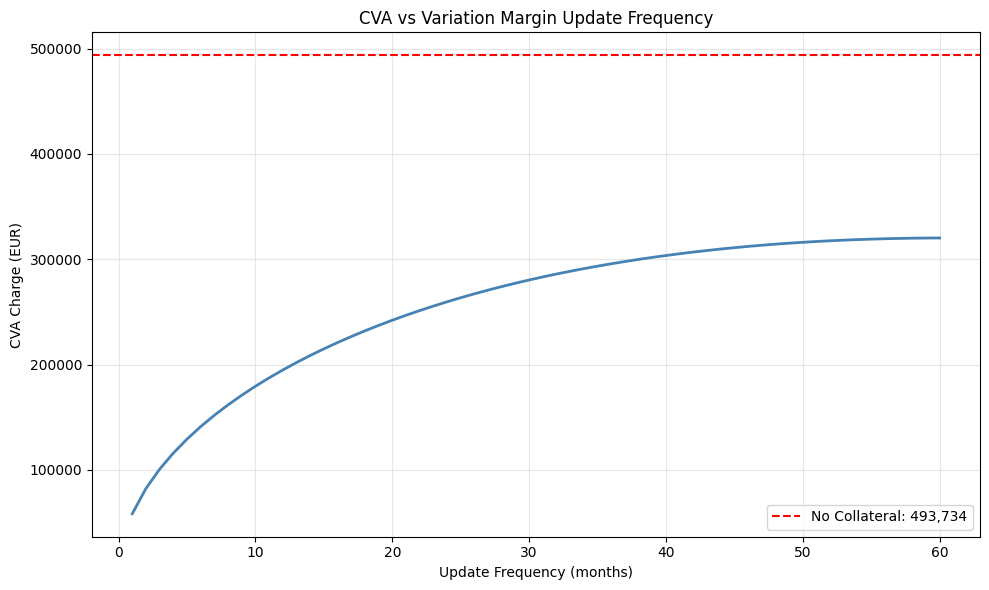


No collateral baseline: 493,734.00
M=1 (monthly updates): 58,356.16
M=12 (annual updates): 194,904.23
M=60 (no updates): 320,244.71


### Question 4b: Initial Margin (Independent Amount)
Initial Margin = 1M EUR: CVA = 470,326.10 (reduction: 4.7%)
Initial Margin = 10M EUR: CVA = 298,477.46 (reduction: 39.5%)
Initial Margin = 100M EUR: CVA = 4,947.16 (reduction: 99.0%)

Baseline (no initial margin): 493,734.00

At IM=100M, CVA = 4,947.16 > 0
Residual risk remains due to tail scenarios where exposure exceeds initial margin.


In [6]:
### Question 4: Collateral Impact on CVA

## a) Variation Margin (Update Frequency)

print("\n### Question 4a: Variation Margin (Update Frequency)")

# Test all update frequencies from 1 to 60 months
margin_frequencies = np.arange(1, 61)
cva_variation_margin = []

for M in margin_frequencies:
    # Calculate collateralized exposure with M-month lag
    collateralized_epe = np.zeros(n_steps + 1)
    
    for time_idx in range(n_steps + 1):
        # Collateral is updated every M months, so use value from M months ago
        collateral_idx = max(0, time_idx - M)
        
        # Current portfolio value
        current_value = V_total[:, time_idx]
        
        # Collateral posted based on value M months ago
        collateral = V_total[:, collateral_idx]
        
        # Effective exposure = max(current_value - collateral, 0)
        effective_exposure = np.maximum(current_value - collateral, 0)
        collateralized_epe[time_idx] = effective_exposure.mean()
    
    cva = calculate_cva(collateralized_epe)
    cva_variation_margin.append(cva)

# Plot CVA vs update frequency
plt.figure(figsize=(10, 6))
plt.plot(margin_frequencies, cva_variation_margin, linewidth=2, color='steelblue')
plt.axhline(y=cva_netted, color='red', linestyle='--', label=f'No Collateral: {cva_netted:,.0f}')
plt.xlabel('Update Frequency (months)')
plt.ylabel('CVA Charge (EUR)')
plt.title('CVA vs Variation Margin Update Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nNo collateral baseline: {cva_netted:,.2f}")
print(f"M=1 (monthly updates): {cva_variation_margin[0]:,.2f}")
print(f"M=12 (annual updates): {cva_variation_margin[11]:,.2f}")
print(f"M=60 (no updates): {cva_variation_margin[-1]:,.2f}")


## b) Initial Margin (Independent Amount)

print("\n\n### Question 4b: Initial Margin (Independent Amount)")

initial_margins = [1_000_000, 10_000_000, 100_000_000]
cva_initial_margin = []

for IM in initial_margins:
    # Calculate exposure with fixed initial margin
    im_epe = np.zeros(n_steps + 1)
    
    for time_idx in range(n_steps + 1):
        # Effective exposure = max(portfolio_value - IM, 0)
        effective_exposure = np.maximum(V_total[:, time_idx] - IM, 0)
        im_epe[time_idx] = effective_exposure.mean()
    
    cva = calculate_cva(im_epe)
    cva_initial_margin.append(cva)
    
    print(f"Initial Margin = {IM/1e6:.0f}M EUR: CVA = {cva:,.2f} (reduction: {((1 - cva/cva_netted)*100):.1f}%)")

print(f"\nBaseline (no initial margin): {cva_netted:,.2f}")

# Show that even at 100M, CVA may not be zero
if cva_initial_margin[-1] > 0:
    print(f"\nAt IM=100M, CVA = {cva_initial_margin[-1]:,.2f} > 0")
    print("Residual risk remains due to tail scenarios where exposure exceeds initial margin.")


**Q5**

In [7]:
### Question 5: Credit Risk Exposure Hedging

## Helper function for CDS pricing

def price_cds(notional, maturity, spread, hazard_rates_dict, lgd=LGD, r=r):
    """Price a CDS contract using piecewise constant hazard rates"""
    dt_cds = 0.25
    times = np.arange(dt_cds, maturity + dt_cds, dt_cds)
    
    protection_leg = 0.0
    for i in range(len(times)):
        t_start = times[i-1] if i > 0 else 0
        t_end = times[i]
        pd = default_probability_custom(t_start, t_end, hazard_rates_dict)
        df = np.exp(-r * t_end)
        protection_leg += lgd * pd * df
    
    premium_leg = 0.0
    for t in times:
        surv_prob = survival_probability_custom(t, hazard_rates_dict)
        df = np.exp(-r * t)
        premium_leg += spread * surv_prob * df * dt_cds
    
    return notional * (protection_leg - premium_leg)


def survival_probability_custom(t, hazard_rates_dict):
    """Calculate survival probability with custom hazard rates"""
    periods = hazard_rates_dict['periods']
    lambdas = hazard_rates_dict['lambdas']
    
    integral = 0.0
    for (t_start, t_end), lambda_val in zip(periods, lambdas):
        if t <= t_start:
            break
        interval_end = min(t, t_end)
        integral += lambda_val * (interval_end - t_start)
    return np.exp(-integral)


def default_probability_custom(t1, t2, hazard_rates_dict):
    """Calculate default probability with custom hazard rates"""
    return survival_probability_custom(t1, hazard_rates_dict) - survival_probability_custom(t2, hazard_rates_dict)


def calculate_cva_with_hazard_rates(hazard_rates_dict):
    """Calculate CVA with custom hazard rates"""
    cva = 0.0
    for i in range(1, len(time_grid)):
        pd = default_probability_custom(time_grid[i-1], time_grid[i], hazard_rates_dict)
        df = np.exp(-r * time_grid[i])
        cva += LGD * pd * df * netted_epe_profile[i]
    return cva


## a) CVA Sensitivities

print("\n### Question 5a: CVA Sensitivities")

bps_shift = 0.001

baseline_hazard = {
    'periods': [(0, 1), (1, 3), (3, 5)],
    'lambdas': [0.0200, 0.0215, 0.0220]
}

cva_baseline = calculate_cva_with_hazard_rates(baseline_hazard)

shifts = [
    ('Increase Forward Hazard Rate [0,1]', 0),
    ('Increase Forward Hazard Rate [1,3]', 1),
    ('Increase Forward Hazard Rate [3,5]', 2)
]

cva_sensitivities = {}

print("\nCVA Sensitivities (+10 bps shift):\n")
for shift_name, bucket_idx in shifts:
    shifted_hazard = {
        'periods': baseline_hazard['periods'].copy(),
        'lambdas': baseline_hazard['lambdas'].copy()
    }
    shifted_hazard['lambdas'][bucket_idx] += bps_shift
    
    cva_shifted = calculate_cva_with_hazard_rates(shifted_hazard)
    delta_cva = cva_shifted - cva_baseline
    
    cva_sensitivities[shift_name] = delta_cva
    print(f"{shift_name}: {delta_cva:,.2f}")


## b) CDS Sensitivities

print("\n\n### Question 5b: CDS Sensitivities")

cds_maturities = [1, 3, 5]
cds_spreads = [0.020, 0.0215, 0.022]

cds_delta_matrix = np.zeros((3, 3))

print("\nCDS Sensitivities (+10 bps shift):\n")
print(f"{'Shift Scenario':<40} {'Δ 1Y CDS':>15} {'Δ 3Y CDS':>15} {'Δ 5Y CDS':>15}")
print("-" * 85)

for shift_idx, (shift_name, bucket_idx) in enumerate(shifts):
    
    for mat_idx, (mat, spread) in enumerate(zip(cds_maturities, cds_spreads)):
        cds_base = price_cds(1_000_000, mat, spread, baseline_hazard)
        
        shifted_hazard = {
            'periods': baseline_hazard['periods'].copy(),
            'lambdas': baseline_hazard['lambdas'].copy()
        }
        shifted_hazard['lambdas'][bucket_idx] += bps_shift
        cds_shifted = price_cds(1_000_000, mat, spread, shifted_hazard)
        
        delta_cds = cds_shifted - cds_base
        cds_delta_matrix[shift_idx, mat_idx] = delta_cds
    
    display_1y = cds_delta_matrix[shift_idx, 0] if bucket_idx == 0 else 0.0
    display_3y = cds_delta_matrix[shift_idx, 1] if bucket_idx <= 1 else 0.0
    display_5y = cds_delta_matrix[shift_idx, 2]
    
    print(f"{shift_name:<40} {display_1y:>15,.2f} {display_3y:>15,.2f} {display_5y:>15,.2f}")


## d) Hedge Construction (Bootstrapping)

print("\n\n### Question 5d: Hedge Construction")

delta_cva_01 = cva_sensitivities['Increase Forward Hazard Rate [0,1]']
delta_cva_13 = cva_sensitivities['Increase Forward Hazard Rate [1,3]']
delta_cva_35 = cva_sensitivities['Increase Forward Hazard Rate [3,5]']

delta_1y_01 = cds_delta_matrix[0, 0]
delta_3y_01 = cds_delta_matrix[0, 1]
delta_5y_01 = cds_delta_matrix[0, 2]

delta_3y_13 = cds_delta_matrix[1, 1]
delta_5y_13 = cds_delta_matrix[1, 2]

delta_5y_35 = cds_delta_matrix[2, 2]

N_5y = -delta_cva_35 / delta_5y_35
residual_13 = delta_cva_13 + N_5y * delta_5y_13
N_3y = -residual_13 / delta_3y_13
residual_01 = delta_cva_01 + N_3y * delta_3y_01 + N_5y * delta_5y_01
N_1y = -residual_01 / delta_1y_01

print("\nOptimal CDS Hedge Notionals (per 1M EUR CDS):")
print(f"  1Y CDS: {N_1y:,.2f}")
print(f"  3Y CDS: {N_3y:,.2f}")
print(f"  5Y CDS: {N_5y:,.2f}")

print("\nHedge Verification (residual CVA sensitivity after hedging):")
hedged_01 = delta_cva_01 + N_1y * delta_1y_01 + N_3y * delta_3y_01 + N_5y * delta_5y_01
hedged_13 = delta_cva_13 + N_3y * delta_3y_13 + N_5y * delta_5y_13
hedged_35 = delta_cva_35 + N_5y * delta_5y_35

print(f"  [0,1] bucket: {hedged_01:,.8f} (target: ~0)")
print(f"  [1,3] bucket: {hedged_13:,.8f} (target: ~0)")
print(f"  [3,5] bucket: {hedged_35:,.8f} (target: ~0)")



### Question 5a: CVA Sensitivities

CVA Sensitivities (+10 bps shift):

Increase Forward Hazard Rate [0,1]: 3,194.82
Increase Forward Hazard Rate [1,3]: 8,187.66
Increase Forward Hazard Rate [3,5]: 10,221.86


### Question 5b: CDS Sensitivities

CDS Sensitivities (+10 bps shift):

Shift Scenario                                  Δ 1Y CDS        Δ 3Y CDS        Δ 5Y CDS
-------------------------------------------------------------------------------------
Increase Forward Hazard Rate [0,1]                396.69          420.71          443.24
Increase Forward Hazard Rate [1,3]                  0.00          747.23          790.86
Increase Forward Hazard Rate [3,5]                  0.00            0.00          674.34


### Question 5d: Hedge Construction

Optimal CDS Hedge Notionals (per 1M EUR CDS):
  1Y CDS: 3.49
  3Y CDS: 5.09
  5Y CDS: -15.16

Hedge Verification (residual CVA sensitivity after hedging):
  [0,1] bucket: -0.00000000 (target: ~0)
  [1,3] bucket: 0.00000000 (target: ~0)
